# 05) Extra ARIMA 

In [25]:
#Doing imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import warnings 

In [98]:
#In order to run the model faster, I had to sample it down to 700,000 instead of nearly 2M
new_df = pd.read_csv('../data/clean/041324_taxi_recs.csv')
new_df = new_df.set_index('req_index')
print(new_df.shape)
new_df.head()

(1947935, 14)


,trip_miles,tips,congestion_surcharge,temp,preciptype,zone,borough_name,trip_duration,month,day_of_month,driver_made,day_of_week,hour,minute
req_index,,,,,,,,,,,,,,
2022-01-04,7.050,7.91,0.00,27.6,0,West Farms/Bronx River,Bronx,25.0,1,4,33.30,Tuesday,7,32
2022-01-04,2.470,0.00,0.00,27.6,0,South Ozone Park,Queens,11.0,1,4,8.33,Tuesday,7,24
2022-01-04,5.310,0.00,2.75,27.6,0,Steinway,Queens,23.0,1,4,18.08,Tuesday,7,24
2022-01-04,3.670,0.00,0.00,27.6,0,Starrett City,Brooklyn,19.0,1,4,17.34,Tuesday,7,24
2022-01-04,2.853,0.00,2.75,27.6,0,Yorkville West,Manhattan,8.0,1,4,7.57,Tuesday,7,24


In [99]:
#Sorting the index by date
new_df = new_df.sort_index()
new_df.shape

(1947935, 14)

In [100]:
#Converting the index to datetime
new_df.index = pd.to_datetime(new_df.index)

In [101]:
#Creating a new dataframe for forecasting with
rev = new_df['driver_made']
rev = pd.DataFrame(rev)
rev

,driver_made
req_index,
2022-01-04,33.30
2022-01-04,8.33
2022-01-04,18.08
2022-01-04,17.34
2022-01-04,7.57
...,...
2022-12-31,33.48
2022-12-31,44.73
2022-12-31,18.60


In [122]:
#Creating a q2 in order to forecast q3
q2 = rev.loc['2022-04-01': '2022-06-30']
q2 = pd.DataFrame(q2)

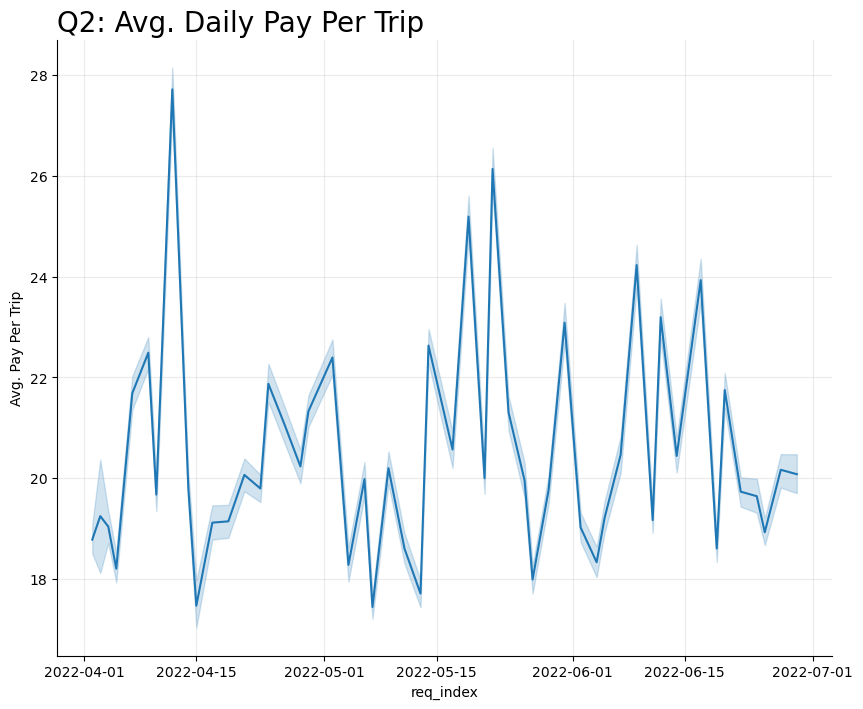

In [123]:
#Plotting Avg. Daily Pay Per Trip for q2

#Setting figure size
plt.figure(figsize=(10,8))

#Grouping q2 by index/days in index
# q2av = q2.groupby(q2.index)['driver_made'].mean()
# q2av = pd.DataFrame(trial)

#Creating plot
sns.lineplot(x=q2.index, y=q2['driver_made'])

#Labeling
#plt.xlabel('Days in Quarter 2')
plt.ylabel('Avg. Pay Per Trip')
plt.title('Q2: Avg. Daily Pay Per Trip', loc='left', fontsize=20);

#Formatting
plt.grid(True, alpha=.25)
sns.despine(right=True, top=True);

In [104]:
#Creating Yt1 and Yt2

In [120]:
q2.head()

,driver_made
req_index,
2022-04-02,8.95
2022-04-02,47.78
2022-04-02,22.13
2022-04-02,40.75
2022-04-02,14.08


In [124]:
#Creating first_diff and second_diff columns to ensure stationarity
q2['first_diff'] = q2['driver_made'].diff()
q2['second_diff'] = q2['driver_made'].diff().diff()
q2.dropna(inplace=True)
q2.head()

,driver_made,first_diff,second_diff
req_index,,,
2022-04-02,22.13,-25.65,-64.48
2022-04-02,40.75,18.62,44.27
2022-04-02,14.08,-26.67,-45.29
2022-04-02,14.86,0.78,27.45
2022-04-02,6.31,-8.55,-9.33


In [125]:
q2.shape 

(493770, 3)

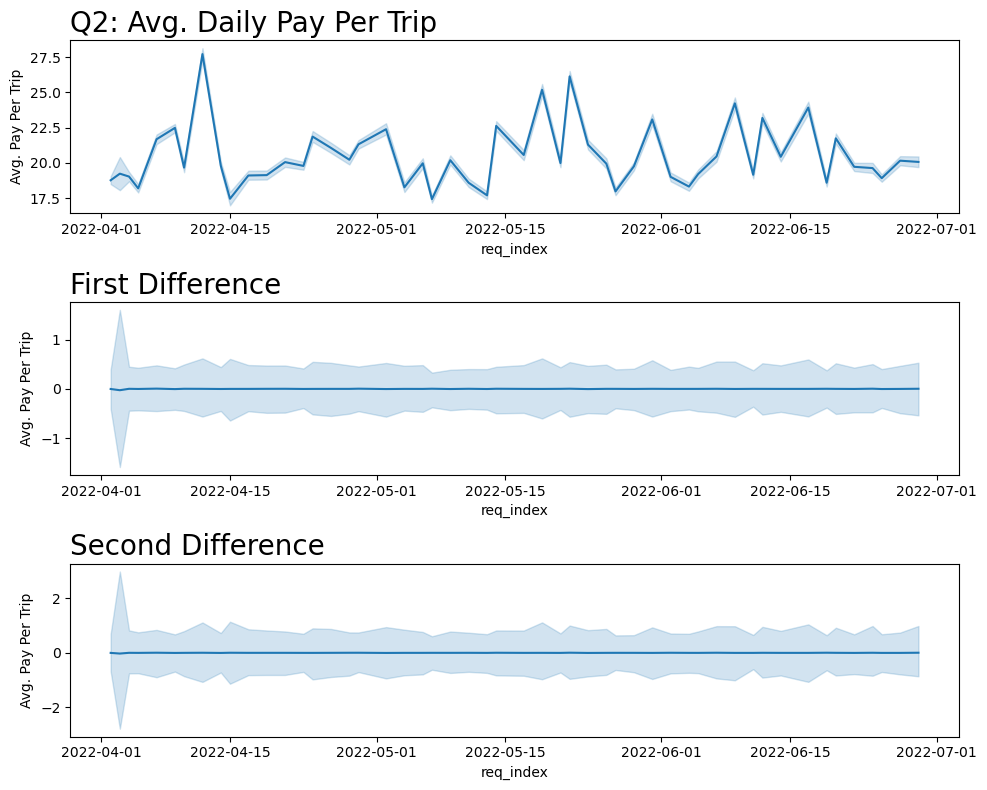

In [126]:
#Plotting to view the stationarity

#Setting figure size
plt.figure(figsize=(10,8))

#Creating plots
plt.subplot(3, 1, 1)
sns.lineplot(x=q2.index, y=q2['driver_made'])
plt.ylabel('Avg. Pay Per Trip')
plt.title('Q2: Avg. Daily Pay Per Trip', loc='left', fontsize=20)

plt.subplot(3, 1, 2)
sns.lineplot(x=q2.index, y=q2['first_diff'])
plt.ylabel('Avg. Pay Per Trip')
plt.title('First Difference', loc='left', fontsize=20)

plt.subplot(3, 1, 3)
sns.lineplot(x=q2.index, y=q2['second_diff'])
plt.ylabel('Avg. Pay Per Trip')
plt.title('Second Difference', loc='left', fontsize=20)


#Formatting
plt.tight_layout()
plt.show();

In [127]:
#Importing and testing Augmented Dickey-Fuller to ensure stationarity

#Importing Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

# Running ADF on original driver data
adfuller(q2['driver_made'])

#2nd number is p-value, it is very close to 0 which is good

(-43.53834741997344,
 0.0,
 101,
 493668,
 {'1%': -3.430363246420677,
  '5%': -2.8615458547618577,
  '10%': -2.566773116275898},
 4209137.642623115)

In [128]:
# Running ADF on first_diff to see if it's becoming more stationary
adfuller(q2['first_diff'])

(-119.63142869793971,
 0.0,
 101,
 493668,
 {'1%': -3.430363246420677,
  '5%': -2.8615458547618577,
  '10%': -2.566773116275898},
 4210974.299590156)

In [129]:
# Running ADF on second_diff to see if it's becoming more stationary
adfuller(q2av['second_diff'])

(-7.5140205595820975,
 3.9466671174612035e-11,
 3,
 43,
 {'1%': -3.5925042342183704,
  '5%': -2.931549768951162,
  '10%': -2.60406594375338},
 171.12249274873437)

## ARIMA Modeling

In [130]:
q2.shape

(493770, 3)

In [131]:
#Creating y variables (X is not needed since X is time)

y_train, y_test = train_test_split(q2['driver_made'], test_size=.1, shuffle=False)

In [132]:
y_train.shape

(444393,)

In [133]:
y_test.shape

(49377,)

In [ ]:
#Finding best p, d, q for the ARIMA model

ps = np.arange(20)
qs = np.arange(20)
scores = []

for p in ps:
    for q in qs:
        model = ARIMA(y_train, order = (p, 1, q)).fit()
        scores.append((p, q, model.aic))

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information an

In [78]:
new_df_scores = pd.DataFrame(scores, columns=['p', 'q', 'aic'])
new_df_scores.sort_values('aic').head()

#Best p, d, q is 0, 1, 1

,p,q,aic
1,0,1,202.785936
21,1,1,204.552109
2,0,2,204.610760
41,2,1,205.271330
43,2,3,205.354873


In [83]:
#Instantiating the model
arima = ARIMA(y_train, order=(0, 1, 1))

#Creating fit
model = arima.fit()

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [94]:
#Getting predictions
preds = model.predict(start=y_test.index[0], end=y_test.index[-1])

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [90]:
print(y_train.index.dtype, y_test.index.dtype)
print(y_train.index)
print(y_test.index[0], y_test.index[-1])

datetime64[ns] datetime64[ns]
DatetimeIndex(['2022-04-04', '2022-04-05', '2022-04-07', '2022-04-09',
               '2022-04-10', '2022-04-12', '2022-04-14', '2022-04-15',
               '2022-04-17', '2022-04-19', '2022-04-21', '2022-04-23',
               '2022-04-24', '2022-04-26', '2022-04-28', '2022-04-29',
               '2022-05-02', '2022-05-04', '2022-05-06', '2022-05-07',
               '2022-05-09', '2022-05-11', '2022-05-13', '2022-05-14',
               '2022-05-17', '2022-05-19', '2022-05-21', '2022-05-22',
               '2022-05-24', '2022-05-26', '2022-05-27', '2022-05-29',
               '2022-05-31', '2022-06-02', '2022-06-04', '2022-06-05',
               '2022-06-07', '2022-06-09', '2022-06-11', '2022-06-12',
               '2022-06-14', '2022-06-17', '2022-06-19', '2022-06-20'],
              dtype='datetime64[ns]', name='req_index', freq=None)
2022-06-22 00:00:00 2022-06-29 00:00:00


/var/folders/1m/70vlnx9n73v__kwg38x_j79h0000gn/T/ipykernel_47891/3122472174.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test[-1]


19.830380952380953